# Utils

## IoU

In [1]:
def IoU(box1, box2):
    # box = (x1, y1, x2, y2)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # obtain x1, y1, x2, y2 of the intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # compute the width and height of the intersection
    w = max(0, x2 - x1 + 1)
    h = max(0, y2 - y1 + 1)

    inter = w * h
    iou = inter / (box1_area + box2_area - inter)
    return iou

## Average Precision

In [2]:
import numpy as np

def average_precision(recalls, precisions):
    """
    Calculate Average Precision (AP) for a single class.

    Parameters:
        recalls: List of recall values.
        precisions: List of precision values.

    Returns:
        AP: float value
    """
    recalls = np.concatenate(([0.], recalls, [1.]))
    precisions = np.concatenate(([0.], precisions, [0.]))

    for i in range(len(precisions) - 1, 0, -1):
        precisions[i - 1] = np.maximum(precisions[i - 1], precisions[i])

    indices = np.where(recalls[1:] != recalls[:-1])[0]
    ap = np.sum((recalls[indices + 1] - recalls[indices]) * precisions[indices + 1])

    return ap

def mean_average_precision(predictions, ground_truths, iou_threshold=0.5):
    """
    Calculate Mean Average Precision (mAP) for object detection.

    Parameters:
        predictions: List of predicted boxes, format [class_id, confidence, x1, y1, x2, y2]
        ground_truths: List of ground truth boxes, format [class_id, x1, y1, x2, y2]
        iou_threshold: float value, IoU threshold to consider a True Positive

    Returns:
        mAP: float value
    """
    class_ids = list(set([box[0] for boxes in ground_truths for box in boxes]))
    average_precisions = []

    for class_id in class_ids:
        class_predictions = [box for boxes in predictions for box in boxes if box[0] == class_id]
        class_ground_truths = [box for boxes in ground_truths for box in boxes if box[0] == class_id]

        if len(class_ground_truths) == 0:
            continue

        class_predictions = sorted(class_predictions, key=lambda x: x[1], reverse=True)

        tp = np.zeros(len(class_predictions))
        fp = np.zeros(len(class_predictions))

        matched_gt_boxes = []

        for i, pred_box in enumerate(class_predictions):
            best_iou = 0
            best_gt_box = None

            for gt_box in class_ground_truths:
                if gt_box in matched_gt_boxes:
                    continue

                iou = IoU(pred_box[2:], gt_box[1:])

                if iou > best_iou:
                    best_iou = iou
                    best_gt_box = gt_box

            if best_iou >= iou_threshold and best_gt_box is not None:
                tp[i] = 1
                matched_gt_boxes.append(best_gt_box)
            else:
                fp[i] = 1

        fp_cumsum = np.cumsum(fp)
        tp_cumsum = np.cumsum(tp)
        recalls = tp_cumsum / len(class_ground_truths)
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum)

        ap = average_precision(recalls, precisions)
        average_precisions.append(ap)

    mAP = np.mean(average_precisions) if len(average_precisions) > 0 else 0.0
    return mAP

# Example usage:
# predictions = [
#     [[0, 0.7, 10, 20, 50, 60], [0, 0.6, 15, 25, 55, 65]],
#     [[1, 0.8, 30, 40, 70, 80]]
# ]

# ground_truths = [
#     [[0, 12, 22, 52, 62]],
#     [[1, 32, 42, 72, 82]]
# ]

# iou_threshold = 0.5
# mAP = mean_average_precision(predictions, ground_truths, iou_threshold)
# print(f"mAP: {mAP}")


## Get mAP score

In [3]:
import os
import cv2

def get_score_map(model, root_folder, image_folder, evc):
    """
    Parameters: 
        model: input model trained with ultralytics
        root_folder: labels folder location
        image_folder: image folder loacation
        evc: evaluation count which means the number of images want to use for evalution
    
    Normailized mAP score has not implemented but I think it is not necessary
    """
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('jpg', 'png'))]
    predictions, ground_truths = [], []
    iou_threshold = 0.5

    map_score = 0
    map_score_normalize = 0
    count = 0
    
    for image_file in image_files:
        if count == evc:
            break
        image = cv2.imread(image_folder + image_file)
        height, width, _ = image.shape
        results = model(image_folder + image_file)
        box_pred = []
        for result in results[0]:
            li = [float(result.boxes.cls), float(result.boxes.conf)]
            for xy in result.boxes.xyxy[0]:
                li.append(float(xy))
            box_pred.append(li)

        box_gt = []
        label_file = image_file[:-3] + "txt"
        with open(root_folder + label_file) as f:
            for l in f:
                parts = l.strip().split()
                gcls, xc, yc, w, h = map(float, parts)
                conv_coor = yolo_to_bbox(gcls, [xc, yc, w, h], float(width), float(height))
                box_gt.append(conv_coor)
        predictions.append(box_pred)
        ground_truths.append(box_gt)

        count += 1
    map_score += mean_average_precision(predictions=predictions, ground_truths=ground_truths, iou_threshold=iou_threshold)
    print("mAP score: " + str(map_score))
    print("mAP score normalized: " + str(map_score_normalize))

    return map_score, map_score_normalize

## YOLO format to Bounding Box format

In [4]:
def yolo_to_bbox(gcls, yolo_bbox, img_width, img_height):
    x_center, y_center, width, height = yolo_bbox
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    x_min = x_center - (width / 2)
    y_min = y_center - (height / 2)
    x_max = x_center + (width / 2)
    y_max = y_center + (height / 2)

    return [gcls, x_min, y_min, x_max, y_max]

# Evaluation
- bar graphs colors refered to [https://www.color-hex.com/color/f1c232]
- Used the colors which can be distinguished easily
- It takes more time if evc gets bigger(set 20 now)

### Alert
- This code is assuming that you have dataset for each scenarios
- You don't have to download whole datasets but only test directories


image 1/1 /Users/han/Han/UCI/Project/BDD100k-daytime/images/test/4cb31f6d-dcf2d353.jpg: 384x640 6 cars, 3 traffic signs, 1 truck, 524.2ms
Speed: 2.0ms preprocess, 524.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/han/Han/UCI/Project/BDD100k-daytime/images/test/7debd2f3-b0e1f7ff.jpg: 384x640 11 cars, 3 traffic lights, 4 traffic signs, 1 truck, 506.8ms
Speed: 1.3ms preprocess, 506.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/han/Han/UCI/Project/BDD100k-daytime/images/test/89536b8a-a4159b08.jpg: 384x640 3 cars, 576.3ms
Speed: 1.3ms preprocess, 576.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/han/Han/UCI/Project/BDD100k-daytime/images/test/1d5d5507-4d202189.jpg: 384x640 7 cars, 3 pedestrians, 7 traffic lights, 9 traffic signs, 533.5ms
Speed: 1.3ms preprocess, 533.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/han/Han/UCI/Proje

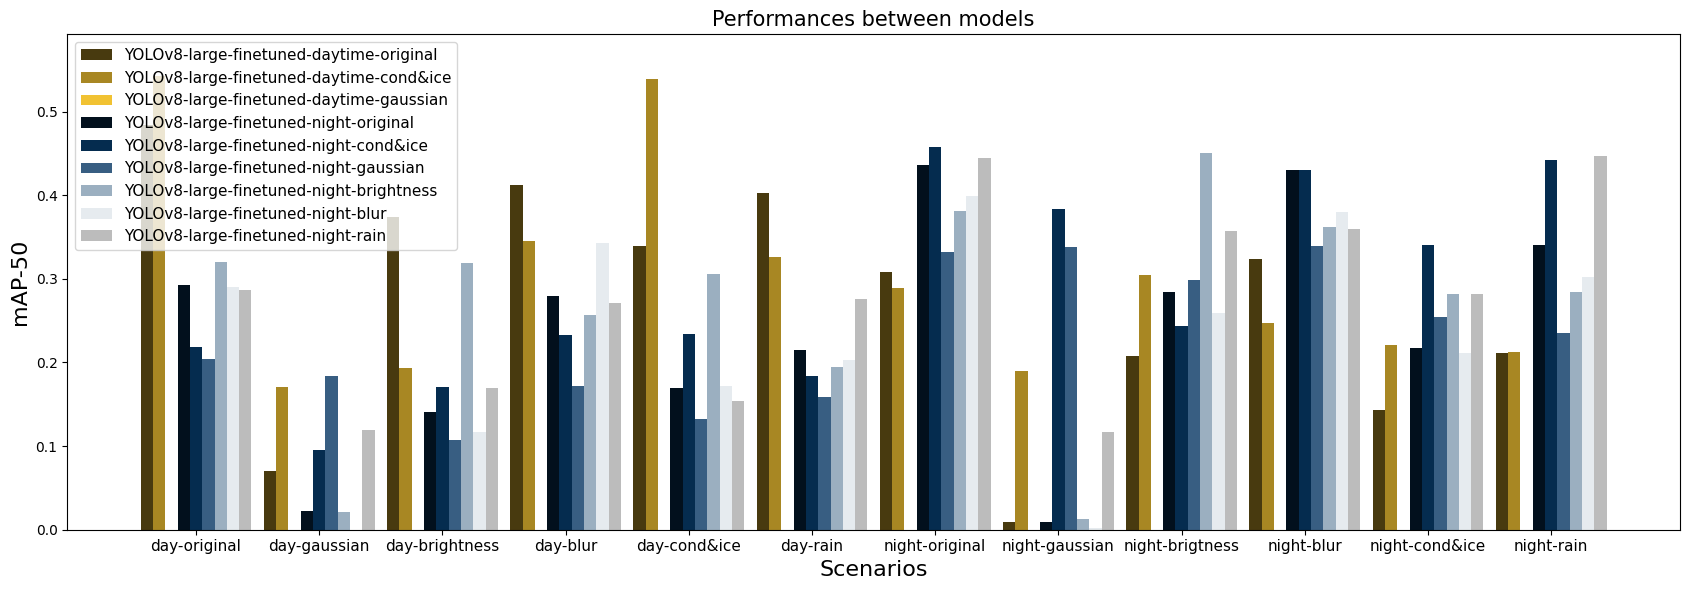

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
import os
import cv2

model1 = YOLO('model/YOLOv8-large-daytime/weights/best.pt')
model2 = YOLO('model/YOLOv8-large-daytime-cond&ice/weights/best.pt')
model3 = YOLO('model/YOLOv8-large-daytime-gaussian-v2/weights/best.pt')
model4 = YOLO('model/YOLOv8-large-night-original/weights/best.pt')
model5 = YOLO('model/YOLOv8-large-night-cond&ice/weights/best.pt')
model6 = YOLO('model/YOLOv8-large-night-gaussian/weights/best.pt')
model7 = YOLO('model/YOLOv8-large-night-brightness/weights/best.pt')
model8 = YOLO('model/YOLOv8-large-night-blur/weights/best.pt')
model9 = YOLO('model/YOLOv8-large-night-rain/weights/best.pt')


categories = ['day-original',
              'day-gaussian',
              'day-brightness',
              'day-blur',
              'day-cond&ice',
              'day-rain',
              'night-original', 
              'night-gaussian',
              'night-brigtness',
              'night-blur', 
              'night-cond&ice',
              'night-rain'
              ]

values1 = []
values2 = []
values3 = []
values4 = []
values5 = []
values6 = []
values7 = []
values8 = []
values9 = []

label_folders = ['BDD100k-daytime/labels/test/', 
                 "BDD100k-daytime-gaussian/labels/test/",
                 'BDD100k-daytime-brightness/labels/test/', 
                 'BDD100k-daytime-blur/labels/test/', 
                 "BDD100k-daytime-cond&ice/labels/test/",
                 'BDD100k-daytime-rain/labels/test/', 
                 'BDD100k/labels/test/',
                 'BDD100k-gaussian/labels/test/',
                 'BDD100k-brightness/labels/test/',
                 'BDD100k-blurness/labels/test/',
                 'BDD100k-cond&ice/labels/test/',
                 'BDD100k-rain/labels/test/'
                 ]

image_folders = ['BDD100k-daytime/images/test/', 
                 "BDD100k-daytime-gaussian/images/test/",
                 'BDD100k-daytime-brightness/images/test/', 
                 'BDD100k-daytime-blur/images/test/', 
                 "BDD100k-daytime-cond&ice/images/test/",
                 'BDD100k-daytime-rain/images/test/', 
                 'BDD100k/images/test/',
                 'BDD100k-gaussian/images/test/',
                 'BDD100k-brightness/images/test/',
                 'BDD100k-blurness/images/test/',
                 'BDD100k-cond&ice/images/test/',
                 'BDD100k-rain/images/test/'
                 ]

for i in range(len(image_folders)):
    values1.append(get_score_map(model=model1, root_folder=label_folders[i], image_folder=image_folders[i], evc=20)[0])
    values2.append(get_score_map(model=model2, root_folder=label_folders[i], image_folder=image_folders[i], evc=20)[0])
    values3.append(get_score_map(model=model3, root_folder=label_folders[i], image_folder=image_folders[i], evc=20)[0])
    values4.append(get_score_map(model=model4, root_folder=label_folders[i], image_folder=image_folders[i], evc=20)[0])
    values5.append(get_score_map(model=model5, root_folder=label_folders[i], image_folder=image_folders[i], evc=20)[0])
    values6.append(get_score_map(model=model6, root_folder=label_folders[i], image_folder=image_folders[i], evc=20)[0])
    values7.append(get_score_map(model=model7, root_folder=label_folders[i], image_folder=image_folders[i], evc=20)[0])
    values8.append(get_score_map(model=model8, root_folder=label_folders[i], image_folder=image_folders[i], evc=20)[0])
    values9.append(get_score_map(model=model9, root_folder=label_folders[i], image_folder=image_folders[i], evc=20)[0])

x = np.arange(len(categories))  
width = 0.1  

fig, ax = plt.subplots(figsize=(17, 6))

ax.bar(x - width*4, values1, width, label='YOLOv8-large-finetuned-daytime-original', color='#483a0f')
ax.bar(x - width*3, values2, width, label='YOLOv8-large-finetuned-daytime-cond&ice', color='#a88723')
ax.bar(x - width*2, values3, width, label='YOLOv8-large-finetuned-daytime-gaussian', color='#f1c232')
ax.bar(x - width*1, values4, width, label='YOLOv8-large-finetuned-night-original', color='#02101d')
ax.bar(x, values5, width, label='YOLOv8-large-finetuned-night-cond&ice', color='#052c4f')
ax.bar(x + width*1, values6, width, label='YOLOv8-large-finetuned-night-gaussian', color='#385e82')
ax.bar(x + width*2, values7, width, label='YOLOv8-large-finetuned-night-brightness', color='#9bafc0')
ax.bar(x + width*3, values8, width, label='YOLOv8-large-finetuned-night-blur', color='#e6ebef')
ax.bar(x + width*4, values9, width, label='YOLOv8-large-finetuned-night-rain', color='#bcbcbc')


ax.set_xlabel('Scenarios', fontsize=16)
ax.set_ylabel('mAP-50', fontsize=16)
ax.set_title('Performances between models', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=11)
ax.legend(fontsize=11)

y_min = min(min(values1), min(values2), min(values3), min(values5), min(values6))
y_max = max(max(values1), max(values2), max(values3), max(values5), max(values6)) + 0.05
ax.set_ylim([y_min, y_max])

fig.tight_layout()

plt.show()

## Plotting graphs
- Just same as above but you can save the results and change the plots with adjust the codes

In [ ]:
x = np.arange(len(categories))  
width = 0.1  

fig, ax = plt.subplots(figsize=(17, 6))

ax.bar(x - width*4, values1, width, label='YOLOv8-large-finetuned-daytime-original', color='#483a0f')
ax.bar(x - width*3, values2, width, label='YOLOv8-large-finetuned-daytime-cond&ice', color='#a88723')
ax.bar(x - width*2, values3, width, label='YOLOv8-large-finetuned-daytime-gaussian', color='#f1c232')
ax.bar(x - width*1, values4, width, label='YOLOv8-large-finetuned-night-original', color='#02101d')
ax.bar(x, values5, width, label='YOLOv8-large-finetuned-night-cond&ice', color='#052c4f')
ax.bar(x + width*1, values6, width, label='YOLOv8-large-finetuned-night-gaussian', color='#385e82')
ax.bar(x + width*2, values7, width, label='YOLOv8-large-finetuned-night-brightness', color='#9bafc0')
ax.bar(x + width*3, values8, width, label='YOLOv8-large-finetuned-night-blur', color='#e6ebef')
ax.bar(x + width*4, values9, width, label='YOLOv8-large-finetuned-night-rain', color='#bcbcbc')


ax.set_xlabel('Scenarios', fontsize=16)
ax.set_ylabel('mAP-50', fontsize=16)
ax.set_title('Performances between models', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=11)
ax.legend(fontsize=11)

y_min = min(min(values1), min(values2), min(values3), min(values5), min(values6))
y_max = max(max(values1), max(values2), max(values3), max(values5), max(values6)) + 0.05
ax.set_ylim([y_min, y_max])

fig.tight_layout()

plt.show()